---
authors: Roel Smit
---

# Entropie 🌶

## Doelen

In hoofdstukken 5 en 6 van het boek wordt er verder ingegaan op de reversibiliteit van processen.
De klassieke mechanica eist alleen behoud van energie en impuls, maar er is geen richtingsvoorkeur in processen.
Dat is in strijd met je dagelijkse ervaring: van een video-opname kun je vrijwel altijd zeggen of deze vooruit of achteruit wordt gespeeld. 

Deze richtingsvoorkeur wordt het best gemodelleerd door de *entropie*.
Dit is een kwantitatieve grootheid die vaak een beetje mysterieus wordt gevonden.
In dit werkblad zullen we kijken of we wat meer over deze entropie te weten kunnen komen.

In dit werkblad komen de volgende onderdelen langs:

- We herhalen de belangrijke stukken code met gekozen constanten en het gedrag van deeltjes.
- We introduceren een nieuwe klasse voor het beheersvolume die de reeds ontwikkelde functies bevat.
- We controleren of deze code gelijkwaardige resultaten geeft als de code in voorgaande werkbladen.
- We bekijken een ingewikkelder modelsysteem van gekoppelde zuigers en kijken hier naar verschillende processen.
- We nemen een reversibele en een niet-reversibele route en kijken naar het verschil in entropie.

## Laden van eerdere code

Net als bij de eerdere simulaties, gaan we uit van dezelfde set van constanten. 

```{exercise} constanten
:label: ex-entropy-01a
Neem de constanten die je in het vorige werkblad hebt gekozen hieronder over. Pas de diameter van de deeltjes aan naar 0.1 nm. LET OP: We hebben de snelheid van de zuiger nogmaals verlaagd. 
```

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
BOX_SIZE_0 = 10.0     # [nm] hoogte en breedte startvolume
N = 40                   # [-] aantal deeltjes
V_0 = 1             #[m/s] startsnelheid
RADIUS = 0.3           # [nm] straal van moleculen
DT = 0.1*RADIUS/V_0              # [s] tijdstap         # [s] tijdstap                  
V_PISTON_0 = -0.02 * V_0     # Startsnelheid van zuiger 
# (negatief betekent zowel links als rechts naar binnen gericht)

#your code/answer


En maken we daarnaast ook gebruik van een klasse die het gedrag van deeltjes omschrijft:

In [29]:
class ParticleClass:
    def __init__(self, m, v, r, R):
        """ maakt een deeltje (constructor) """
        self.m = m                         
        self.v = np.array(v, dtype=float)  
        self.r = np.array(r, dtype=float)  
        self.R = R

    def update_position(self):
        """ verandert positie voor één tijdstap """
        self.r += self.v * DT 
            
    @property
    def momentum(self):
        return self.m * self.v
    
    @property
    def kin_energy(self):
        return 1/2 * self.m * np.dot(self.v, self.v)
    
def collide_detection(p1: ParticleClass, p2: ParticleClass) -> bool:
    """ Geeft TRUE als de deeltjes overlappen """
    dx = p1.r[0] - p2.r[0]
    dy = p1.r[1] - p2.r[1]
    rr = p1.R + p2.R
    return  dx**2+dy**2 < rr**2 

def particle_collision(p1: ParticleClass, p2: ParticleClass):
    """ past snelheden aan uitgaande van overlap """
    m1, m2 = p1.m, p2.m
    delta_r = p1.r - p2.r
    delta_v = p1.v - p2.v
    dot_product = np.dot(delta_r, delta_v)
    # Als deeltjes van elkaar weg bewegen dan geen botsing
    if dot_product >= 0: # '='-teken voorkomt ook problemen als delta_r == \vec{0}
        return
    distance_squared = np.dot(delta_r, delta_r) 
    # Botsing oplossen volgens elastische botsing in 2D
    p1.v -= 2 * m2 / (m1 + m2) * dot_product / distance_squared * delta_r
    p2.v += 2 * m1 / (m1 + m2) * dot_product / distance_squared * delta_r

## Het beheersvolume

In het boek wordt er vaak gesproken over een 'control volume'.
Dit is een reëel of denkbeeldig volume waaraan een aantal macroscopische eigenschappen worden toegekend.
Het Nederlandse woord hiervoor is 'beheersvolume'.
Veel van de functies die we tot nu toe hebben ontwikkeld gaan over eigenschappen en gedrag van een dergelijk beheersvolume - deze hebben we slechts impliciet gebruikt.
Om de code beter te structureren, maken we hier een klasse voor.
Dit maakt het vooral makkelijk om bijvoorbeeld met twee beheersvolumes te rekenen (later in dit werkblad is dat ons doel).

Als je de code hieronder vergelijkt met die van de vorige werkbladen, zal je een aantal zaken opvallen: 

- Elke functie heeft een parameter `self` gekregen. Daarmee begrijpt Python dat het om een functie van de klasse gaat.
- De variabelen die als `global` stonden vermeld zijn nu een variabele van de klasse en hoeven dus niet meer gedeclareerd te worden in elke functie. Ze moeten in de code wel telkens worden voorafgegaan door het woord `self`, om dit duidelijk te maken. 
- Om de eigenschappen `heat`, `work` en `pressure` alleen te laten lezen en niet te laten schrijven, maken we gebruik van een [Python conventie](https://www.datacamp.com/tutorial/role-underscore-python) waarbij we een 'geheime' variabele gebruiken die wordt voorafgegaan door een laag liggend streepje '_' (Engels: underscore). 

```{exercise} temperatuur
:label: ex-entropy-01b
Plaats in deze code voor de klasse `ControlVolume` de code voor de temperatuur. Deze heb je in de vorige werkbladen ook telkens aangebracht, maar moet volgens bovenstaande punten een klein beetje worden aangepast, omdat het in de klasse geplaatst wordt.
```

In [30]:
class ControlVolume:
    def __init__(self, length, height, N, v_piston, set_temp):
        """ maakt een beheersvolume (constructor) """
        self.length = length
        self.height = height 
        self.v_piston = v_piston
        self.set_temp = set_temp
        self.particles = []
        self._work = 0.0
        self._heat = 0.0
        self._impulse_out = 0.0
        self._pressure = 0.0
        for _ in range(N):
            vx = np.random.uniform(-V_0, V_0)
            vy = np.random.choice([-1, 1]) * np.sqrt(V_0**2 - vx**2)        
            x = np.random.uniform(-self.length/2 + RADIUS, self.length/2 - RADIUS)
            y = np.random.uniform(-self.height/2 + RADIUS, self.height/2 - RADIUS)
            self.particles.append(ParticleClass(m=1.0, v=[vx, vy], r=[x, y], R=RADIUS))

    def handle_collisions(self) -> None:
        """ alle onderlinge botsingen afhandelen voor deeltjes in lijst """
        num_particles = len(self.particles)
        for i in range(num_particles):
            for j in range(i+1, num_particles):
                if collide_detection(self.particles[i], self.particles[j]):
                    particle_collision(self.particles[i], self.particles[j])

    def piston_collision(self, particle: ParticleClass) -> None:
        """ verzorgen van botsingen met wand links en rechts, die als zuiger kunnen bewegen """
        if abs(particle.r[0]) + particle.R > self.length / 2:
            particle.r[0] = np.sign(particle.r[0]) * (self.length/2 - particle.R)
            piston_velocity = np.sign(particle.r[0]) * self.v_piston
            relative_velocity = particle.v[0] - piston_velocity  # stelsel zuiger
            particle.v[0] = -relative_velocity + piston_velocity # stelsel waarnemer
            self._impulse_out += 2 * particle.m * abs(relative_velocity)
            self._work += 2 * particle.m * relative_velocity * piston_velocity

    def thermostat_collision(self, particle: ParticleClass) -> None:
        """ verzorgen van botsingen met wand boven en onder, die als thermostaat kunnen werken """
        if abs(particle.r[1]) + particle.R > self.height / 2:
            temp_factor = (self.set_temp/self.temperature) if self.set_temp > 0 else 1.0
            particle.r[1] = np.sign(particle.r[1]) * (self.height/2 - particle.R)
            self._impulse_out += abs(particle.momentum[1]) * (1 + temp_factor**0.5) 
            self._heat += particle.kin_energy * (temp_factor - 1)
            particle.v *= temp_factor**0.5
            particle.v[1] *= -1

    def handle_walls(self) -> None:
        """ verzorgen van alle botsingen met wanden en aanpassen waarde voor druk """
        self._impulse_out = 0.0
        for p in self.particles:
            self.piston_collision(p)
            self.thermostat_collision(p)
        self._pressure = 0.95 * self._pressure + 0.05 * self._impulse_out / (self.circumference * DT)

    def take_time_step(self) -> None:
        self.length += 2 * self.v_piston * DT # zowel links als rechts zuiger
        for p in self.particles:
            p.update_position()
        self.handle_collisions()
        self.handle_walls()  

    @property
    def temperature(self) -> float:
        k_B = 1.380649e-23
        f = 2
        M_AIR = 29 * 1.66e-27

        E = 0.0
        for p in self.particles:
            v_si = p.v * 420
            E += 0.5 * M_AIR * np.dot(v_si, v_si)

        E_avg = E / len(self.particles)

        T = (2 * E_avg) / (f * k_B)

        return T

    @property
    def area(self) -> float:
        return self.length * self.height
    
    @property 
    def circumference(self) -> float:
        return 2 * (self.length + self.height)
    
    @property
    def heat(self) -> float:
        return self._heat
    
    @property
    def work(self) -> float:
        return self._work
    
    @property
    def pressure(self) -> float:
        return self._pressure

## Herhaling oude test

Om zeker te zijn dat de code functioneert herhalen we eerst een berekening, waarvan we het antwoord al kennen.
Dit is de simulatie van de druk en de temperatuur als functie van het volume voor een isotherm proces (waarbij de temperatuur dus constant wordt gehouden met behulp van een thermostaat).

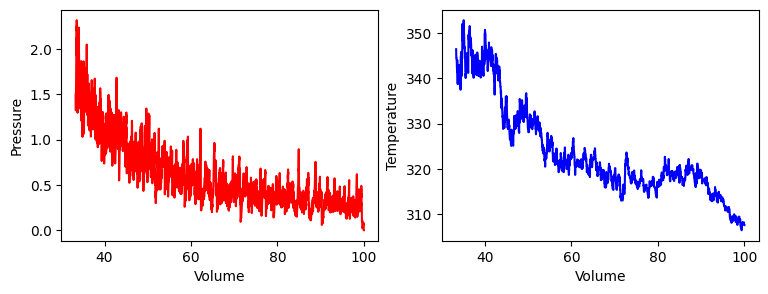

In [31]:
num_steps = round(2/3 * BOX_SIZE_0 / (2 * -V_PISTON_0 * DT))

volumes = np.zeros(num_steps, dtype=float)
pressures = np.zeros(num_steps, dtype=float)
temperatures = np.zeros(num_steps, dtype=float)

cv = ControlVolume(BOX_SIZE_0, BOX_SIZE_0, 40, V_PISTON_0, 300)

for i in range(num_steps):
    cv.take_time_step()
    volumes[i] = cv.area
    pressures[i] = cv.pressure
    temperatures[i] = cv.temperature

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
ax1.set_xlabel('Volume')
ax1.set_ylabel('Pressure')
ax2.set_xlabel('Volume')
ax2.set_ylabel('Temperature')
fig.tight_layout

ax1.plot(volumes, pressures, '-r')
ax2.plot(volumes, temperatures, '-b')

plt.show()

```{exercise} controle
:label: ex-entropy-02
Verifieer de uitkomst van deze testsimulatie en vergelijk de uitkomst met een vorig werkblad. Corrigeer de code als er vergissingen in zijn geslopen.
```

## Systeem van twee gekoppelde zuigers

Om nu een studie te doen naar de entropie van een systeem maken we gebruik van twee gekoppelde zuigers, zie {numref}`fig_gek_zuig`.
Dit zijn twee zuigers genummerd '1' en '2' die samen een constant volume hebben, maar waarbij de beweging van de zuiger(s) het ene volume verkleint en het andere volume evenveel vergroot.
Dit systeem houden we voor de rest van dit weerkblad thermisch geïsoleerd ten opzichte van de omgeving, zodat we een goede boekhouding kunnen doen van de totale hoeveelheid energie. 

```{figure} ../../Figures/gekoppelde_zuiger.png
:width: 60%
:label: fig_gek_zuig

De gekoppelde zuigers, waarbij het totaal volume constant is.
```


```{note}
Als je heel precies kijkt, dan heeft elk volume in onze Pythoncode twee zuigerwanden: één aan de linker en één aan de rechter kant van het volume.
Wil je het beeld geheel kloppend hebben, dan moet je je voorstellen dat de twee (2D-)volumes op het oppervlak van een cilinder zitten, waarbij de twee zuigers in tegengestelde richtingen bewegen.
Beide zuigerwanden verkleinen zo samen hetzelfde volume en maken het andere groter. 
```

### Isotherme verplaatsing

Als eerste kijken we naar het reversibele proces.
We herhalen dat er geen thermisch contact is met de omgeving, maar er is wel thermisch contact tussen de twee volumes zodat ze constant dezelfde temperatuur hebben. 

In de onderstaande code beginnen we met twee beheersvolumes `cv1` en `cv2`, die aan het begin hetzelfde volume $V_0$ hebben.
Dan verplaatsen we de zuiger(s) met een constante snelheid naar het punt waar $V_1=\frac{1}{5}V_0$ en $V_2= \frac{9}{5} V_0$ (wat verwacht je, conceptueel, wat er gebeurt met de verschillende grootheden?)

Hieronder vind je het verloop van de druk en de temperatuur van beide volumes tijdens dit proces.

```{exercise} reversibel
:label: ex-entropy-03
Er stroomt gedurende dit experiment warmte tussen de twee beheersvolumes. 
Waarom is het (idealiter) toch een reversibel proces?
```

```{solution} ex-entropy-03
Omdat beide volumes idealiter dezelfde temperatuur hebben, is er geen entropieproductie.

Daardoor geldt dat de entropieverandering wordt gegeven door
dS = δQ / T

En over de volledige cyclus:

∮ dS = 0

Dus de totale entropieverandering is nul en het proces is reversibel.
```

In [32]:
# runnen van de simulatie
num_data = round(abs(BOX_SIZE_0 * 0.4 / (DT * V_PISTON_0)))

volumes1 = np.zeros(num_data, dtype=float)
pressures1 = np.zeros(num_data, dtype=float)
temperatures1 = np.zeros(num_data, dtype=float)
volumes2 = np.zeros(num_data, dtype=float)
pressures2 = np.zeros(num_data, dtype=float)
temperatures2 = np.zeros(num_data, dtype=float)

cv1 = ControlVolume(BOX_SIZE_0, BOX_SIZE_0, 50, +V_PISTON_0, 0.5)
cv2 = ControlVolume(BOX_SIZE_0, BOX_SIZE_0, 50, -V_PISTON_0, 0.5)

for i in range(num_data):
    cv1.take_time_step()
    cv2.take_time_step()
    
    average_temp = (cv1.temperature + cv2.temperature) / 2
    cv1.set_temp = average_temp
    cv2.set_temp = average_temp
    
    volumes1[i] = cv1.area
    pressures1[i] = cv1.pressure
    temperatures1[i] = cv1.temperature
    
    volumes2[i] = cv2.area
    pressures2[i] = cv2.pressure
    temperatures2[i] = cv2.temperature

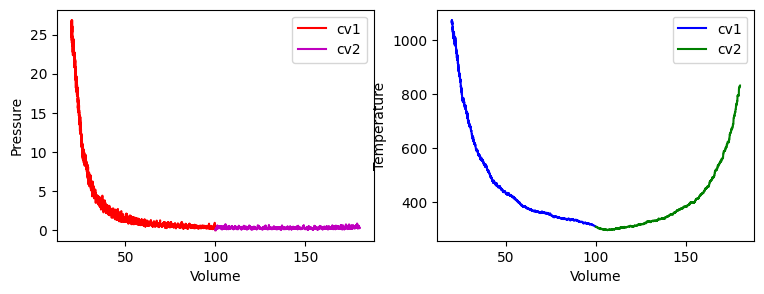

In [33]:
# plotten van de druk en temperatuur van beide volumes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
ax1.set_xlabel('Volume')
ax1.set_ylabel('Pressure')

ax2.set_xlabel('Volume')
ax2.set_ylabel('Temperature')
fig.tight_layout

#druk als functie van volume
ax1.plot(volumes1, pressures1, '-r', label='cv1')
ax1.plot(volumes2, pressures2, '-m',label='cv2')
ax1.legend()

#temperatuur als functie van volume
ax2.plot(volumes1, temperatures1, '-b',label='cv1')
ax2.plot(volumes2, temperatures2, '-g',label='cv2')
ax2.legend()

plt.show()

```{exercise} toename temperatuur
:label: ex-entropy-04
Leg uit waarom de temperatuur van het systeem toeneemt als de zuiger een uitwijking krijgt ten opzichte van het midden.
Leg daarna ook uit waarom deze toename in temperatuur steeds sneller gaat voor grotere uitwijking.
```

```{solution} ex-entropy-04
Wanneer de zuiger een uitwijking krijgt, verandert het volume van het gas. Bij een uitwijking naar binnen wordt het volume kleiner, waardoor dezelfde hoeveelheid deeltjes in minder ruimte zit. Daardoor botsen de deeltjes vaker tegen de wand en tegen de bewegende zuiger. Bij zo’n botsing wordt arbeid op het gas verricht, waardoor de inwendige energie toeneemt. Omdat de temperatuur een maat is voor de gemiddelde kinetische energie van de deeltjes, stijgt de temperatuur dus.

Bij grotere uitwijkingen wordt het volume nog kleiner. De druk neemt dan sterker toe en de botsingen worden nog frequenter en energieker. Per extra stukje verplaatsing wordt er daardoor meer arbeid op het gas verricht. Daarom neemt de temperatuur steeds sneller toe naarmate de uitwijking groter wordt.
```

```{exercise} temperatuurverschil
:label: ex-entropy-05
Als je naar de temperatuur van de twee volumes kijkt (weergegeven in blauw en groen in de rechter grafiek), dan zijn deze onderling telkens een beetje verschillend.
Welke grootheid heeft de grootste invloed op dit verschil en waarom? (Verander de waardes in de simulatie om dit te onderzoeken en te controleren)
``` 

```{solution} ex-entropy-05
De snelheid van de deeltjes en vooral de snelheid van de zuiger heeft de grootste invloed op het temperatuurverschil.

Als de zuiger sneller beweegt, worden de botsingen tussen de deeltjes en de zuiger minder quasi-statisch en energieker. Daardoor wordt er ongelijk arbeid op beide volumes verricht. Het volume dat kleiner wordt, krijgt meer en hardere botsingen per tijdseenheid, waardoor de gemiddelde kinetische energie van de deeltjes daar sterker toeneemt.

Omdat temperatuur direct samenhangt met de gemiddelde kinetische energie, ontstaat er dan een groter temperatuurverschil tussen de twee volumes. Bij lagere zuigersnelheden (meer quasi-statisch) blijft het temperatuurverschil juist kleiner.
```

Dit systeem is zo gekozen dat het mogelijk is om de temperatuur analytisch te bepalen met behulp van een wiskundige afleiding.
We gaan ervan uit dat het systeem bij de start helemaal symmetrisch is (zoals in de simulatie) en definiëren hierbij $x$ als de positie van de zuiger.
Bij $x=-1$ staat de zuiger helemaal aan de kant van `cv1`, zodat $V_1=0$ en $V_2=2V_0$.
Bij $x=+1$ staat de zuiger helemaal aan de andere kant, zodat $V_1=2V_0$ en $V_2=0$. 
Dan moet dus gelden dat:

$$
    V_1 = V_0 (1+x) \text{ en } V_2 = V_0 (1-x).
$$

Omdat ons gas twee vrijheidsgraden heeft, wordt de interne energie van elk van de volumes ($i \in {1,2}$) gegeven door:

$$
    U_i = \frac{2}{2} N_i k_B T.
$$

Met het aantal deeltjes aan beide kanten gelijk betekent dit voor de interne energie van het totale systeem

$$
    dU = dU_1 + dU_2 = 2N k_B dT.
$$

Voor het verplaatsen van de zuiger geldt voor beide kanten:

$$
    \delta W_i = P_i dV_i = \frac{N k_B T}{V_i} dV_i.
$$

Als we deze twee formules samennemen dan levert dit:

$$
    -N k_B T \left( \frac{dV_1}{V_1} + \frac{dV_2}{V_2} \right) = 2 N k_B dT.
$$

Vullen we de startformules voor $V_1$ en $V_2$ in, dan wordt dit:

$$
    \frac{dT}{dx} = \frac{x}{1-x^2}T.
$$

```{exercise} energiebalans
:label: ex-entropy-06
In de bovenstaande afleiding is gebruik gemaakt van de relatie $dU=-\delta W$. Waarom kan je dat in dit geval stellen?
```

```{solution} ex-entropy-06
Omdat het totale systeem thermisch geïsoleerd is geldt dQ = 0.

Volgens de eerste hoofdwet:
dU = dQ − δW

Met dQ = 0 volgt:
dU = −δW

De verandering in interne energie wordt dus volledig veroorzaakt door de arbeid van de zuiger.

```

```{exercise} theorie
:label: ex-entropy-07
Los de differentiaalvergelijking op en plot deze theoretische voorspelling voor de temperatuur samen met het resultaat van de simulatie van hierboven.
(LET OP: Dit gaat dus niet om een fit, maar om een theoretische voorspelling die volledig gegeven wordt door de begincondities)
```

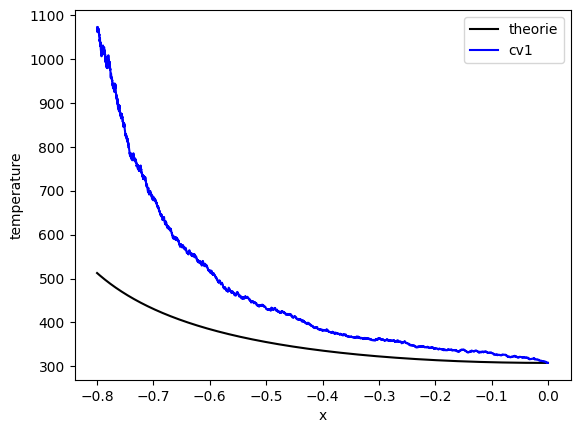

In [34]:
# your code/answer
def temp(x, T0):
    return T0 * np.exp(-0.5 * np.log(1 - x**2))   # = T0 / sqrt(1 - x^2)

# beginwaarde uit simulatie
T0 = temperatures1[0]

# x uit volume-relatie: V1 = V0 (1 + x)
V0 = volumes1[0]
x_vals = volumes1 / V0 - 1

temperatuur = temp(x_vals, T0)

plt.figure()
plt.xlabel('x')
plt.ylabel('temperature')

plt.plot(x_vals, temperatuur, 'k', label='theorie')
plt.plot(x_vals, temperatures1, '-b', label='cv1')
# plt.plot(x_vals, temperatures2c, '-g', label='cv2')

plt.legend()
plt.show()





```{exercise} theoretical_error
:label: ex-entropy-08
Zie je afwijkingen tussen de theorie en de simulatie? Bespreek deze en leg uit waardoor ze worden veroorzaakt.
```

```{solution} ex-entropy-08
Ja, er zijn duidelijke afwijkingen zichtbaar. De simulatie (blauw) ligt systematisch boven de theoretische voorspelling (zwart), vooral bij grotere uitwijkingen.

De theorie gaat uit van een volledig quasi-statisch en reversibel proces. In de simulatie beweegt de zuiger echter met een eindige snelheid. Daardoor ontstaan niet-evenwichtseffecten: extra dissipatie, lokale temperatuurverschillen en statistische fluctuaties door het beperkte aantal deeltjes.

Daarnaast bevat de simulatie numerieke discretisatiefouten (eindige tijdstap). Deze effecten zorgen ervoor dat er effectief extra arbeid in het gas terechtkomt, waardoor de temperatuur hoger uitvalt dan de ideale theoretische voorspelling.

```

Om te verifiëren dat dit proces reversibel is moeten we het proces ook terug kunnen uitvoeren. 

```{exercise} reversibel
:label: ex-entropy-09
Beweeg de zuiger terug en controleer de reversibiliteit van het proces
```

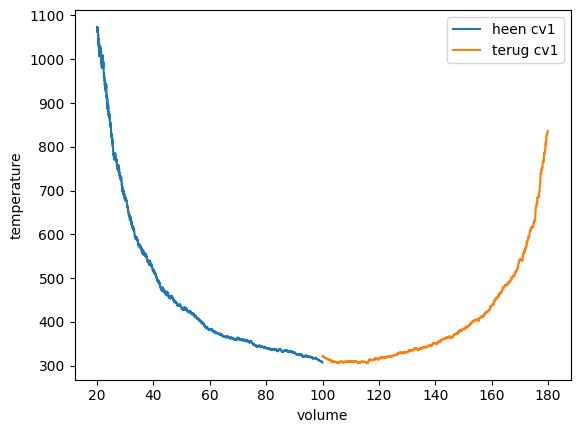

307.5327617663868
836.381211627179


In [35]:
num_data = round(abs(BOX_SIZE_0 * 0.4 / (DT * V_PISTON_0)))

volumes1_back = np.zeros(num_data, dtype=float)
temperatures1_back = np.zeros(num_data, dtype=float)
volumes2_back = np.zeros(num_data, dtype=float)
temperatures2_back = np.zeros(num_data, dtype=float)

cv1_back = ControlVolume(BOX_SIZE_0, BOX_SIZE_0, 50, -V_PISTON_0, 0.5)
cv2_back = ControlVolume(BOX_SIZE_0, BOX_SIZE_0, 50, +V_PISTON_0, 0.5)

cv1_back.set_temp = temperatures1[-1]
cv2_back.set_temp = temperatures2[-1]

for i in range(num_data):
    cv1_back.take_time_step()
    cv2_back.take_time_step()
    
    average_temp = (cv1_back.temperature + cv2_back.temperature) / 2
    cv1_back.set_temp = average_temp
    cv2_back.set_temp = average_temp
    
    volumes1_back[i] = cv1_back.area
    temperatures1_back[i] = cv1_back.temperature
    
    volumes2_back[i] = cv2_back.area
    temperatures2_back[i] = cv2_back.temperature

plt.figure()
plt.plot(volumes1, temperatures1, label='heen cv1')
plt.plot(volumes1_back, temperatures1_back, label='terug cv1')
plt.xlabel('volume')
plt.ylabel('temperature')
plt.legend()
plt.show()

print(temperatures1[0])
print(temperatures1_back[-1])




```{exercise} check reversibility
:label: ex-entropy-10
Je ziet dat het proces terug niet helemaal overeenkomt met dat op de heenweg. Beschrijf de verschillen en leg uit waar deze vandaan komen. Welke parameters kan je veranderen aan de simulatie om de reversibiliteit te verhogen? Zal het je lukken dit helemaal perfect te krijgen?
```

```{solution} ex-entropy-10
De terugweg valt niet precies samen met de heenweg. Bij hetzelfde volume is de temperatuur iets anders en de eindtemperatuur komt niet exact terug op de beginwaarde. Dat betekent dat het proces in de simulatie niet perfect reversibel is.

Dit komt doordat de zuiger met een eindige snelheid beweegt en het systeem dus niet volledig quasi-statisch is. Ook zorgen de tijdstap en het beperkte aantal deeltjes voor kleine fouten en fluctuaties.

Je kan de reversibiliteit verbeteren door de zuigersnelheid kleiner te maken, de tijdstap te verkleinen en meer deeltjes te gebruiken. Helemaal perfect wordt het nooit door numerieke en statistische effecten.

```

### Adiabatische verplaatsing zuiger

We kunnen in een vergelijkbare eindsituatie komen door de zuiger eerst adiabatisch te verplaatsen (dat wil zeggen: zonder onderling thermisch contact tussen de volumes) en pas daarna het thermische contact toe te staan.
Om dat in onze simulatie te modelleren concentreren we ons eerst op de adiabatische verplaatsing van de zuigerwand en nemen we het thermische contact nog niet mee.

```{exercise} adiabatisch
:label: ex-entropy-11
Welke eindtemperatuur verwacht je na dit adiabatische proces voor de twee volumes als het om een ideaal gas gaat en we de zuiger net zoveel verplaatsen als in het vorige experiment?
```

```{solution} ex-entropy-11
#your code/answer
```
Bij een adiabatisch proces is er geen warmte-uitwisseling. De temperatuur verandert alleen door arbeid op het gas.

Voor dit ideale gas met twee vrijheidsgraden geldt:

$$
T V = \text{constant}
$$

Dus:

$$
T \propto \frac{1}{V}
$$

Als:

$$
V_1 = \frac{1}{5} V_0
\qquad
V_2 = \frac{9}{5} V_0
$$

dan volgt:

$$
T_1 = 5 T_0
\qquad
T_2 = \frac{5}{9} T_0
$$

Het kleinere volume krijgt dus een hogere temperatuur

```{exercise}
:label: ex-entropy-12
Maak een code voor een adiabatische verplaatsing voor de zuigerwand van de positie $x=0$ naar de positie $x=-0.8$.
Je kan hiervoor het best starten vanuit de code voor het isotherme proces en deze aanpassen.
```

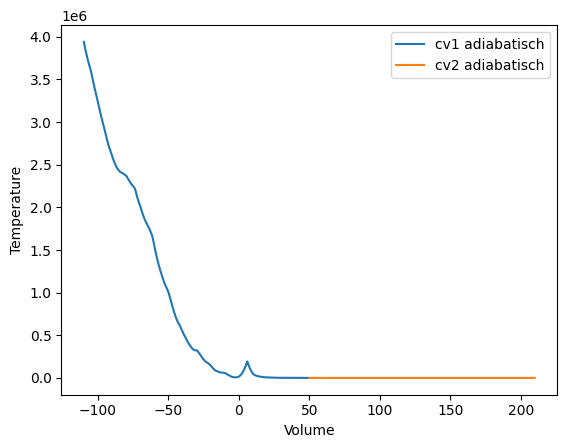

In [40]:
num_data = round(abs(BOX_SIZE_0 * 0.8 / (DT * V_PISTON_0)))

volumes1_ad = np.zeros(num_data)
temperatures1_ad = np.zeros(num_data)
volumes2_ad = np.zeros(num_data)
temperatures2_ad = np.zeros(num_data)

cv1_ad = ControlVolume(BOX_SIZE_0/2, BOX_SIZE_0, 50, +V_PISTON_0, -1)
cv2_ad = ControlVolume(BOX_SIZE_0/2, BOX_SIZE_0, 50, -V_PISTON_0, -1)

for i in range(num_data):
    cv1_ad.length += 2 * cv1_ad.v_piston * DT
    cv2_ad.length -= 2 * cv1_ad.v_piston * DT

    for p in cv1_ad.particles:
        p.update_position()
    for p in cv2_ad.particles:
        p.update_position()

    cv1_ad.handle_collisions()
    cv2_ad.handle_collisions()

    cv1_ad.handle_walls()
    cv2_ad.handle_walls()

    volumes1_ad[i] = cv1_ad.area
    temperatures1_ad[i] = cv1_ad.temperature
    volumes2_ad[i] = cv2_ad.area
    temperatures2_ad[i] = cv2_ad.temperature

plt.figure()
plt.plot(volumes1_ad, temperatures1_ad, label='cv1 adiabatisch')
plt.plot(volumes2_ad, temperatures2_ad, label='cv2 adiabatisch')
plt.xlabel('Volume')
plt.ylabel('Temperature')
plt.legend()
plt.show()



Na de adiabatische verplaatsing moeten de twee volumes alsnog in thermisch evenwicht gebracht worden. Dat doen we met de code hieronder. 

```{exercise} evenwicht
:label: ex-entropy-13
Wat is de theoretische eindtemperatuur $T_{\text{eq}}$ als we deze twee volumes vervolgens in thermisch evenwicht laten komen?
```

```{solution} ex-entropy-13
Omdat in beide volumes hetzelfde ideale gas zit en het aantal deeltjes gelijk is, is de inwendige energie recht evenredig met de temperatuur.

Bij thermisch evenwicht wordt de totale energie behouden. De eindtemperatuur wordt daarom het gemiddelde van de twee begin­temperaturen:

T_eq = (T_1 + T_2) / 2

Dus de twee volumes komen uit op de gemiddelde temperatuur.


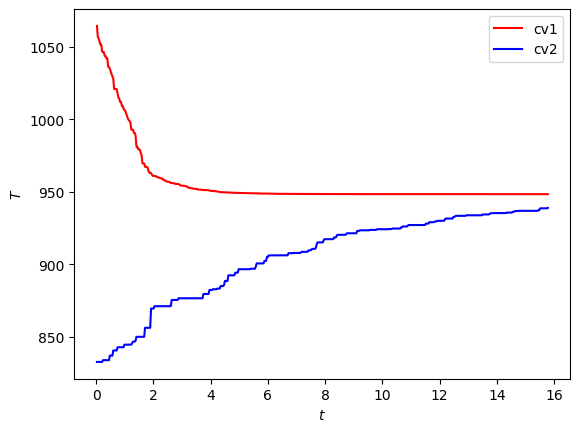

In [37]:
times = []
temp1 = []
temp2 = []

average_temp = (cv1.temperature + cv2.temperature) / 2
cv1.set_temp = average_temp
cv2.set_temp = average_temp
cv1.v_piston = 0.0
cv2.v_piston = 0.0
time = 0.0

while cv2.temperature < 0.99 * cv2.set_temp:
    time += DT
    cv1.take_time_step()
    cv2.take_time_step()
    temp1.append(cv1.temperature)
    temp2.append(cv2.temperature)
    times.append(time)

plt.figure()
plt.xlabel('$t$')
plt.ylabel('$T$')

plt.plot(times, temp1, '-r', label='cv1')
plt.plot(times, temp2, 'b-', label='cv2')
plt.legend()

plt.show()




```{exercise} wrong-contact
:label: ex-entropy-14
Als je kritisch naar de code kijkt staan de twee volumes helemaal niet in thermisch contact met elkaar, maar gebeurt er iets anders.
Omschrijf dat proces en leg uit waarom je hierbij toch hetzelfde antwoord verwacht.
```

```{solution} ex-entropy-14
De twee volumes staan hier niet echt in thermisch contact met elkaar. In plaats daarvan wordt eerst de gemiddelde temperatuur berekend en daarna als vaste set_temp opgelegd aan beide volumes. 

De boven- en onderwand werken dus als thermostaat die elk volume afzonderlijk naar die gemiddelde temperatuur stuurt.

Het is dus geen directe warmte-uitwisseling tussen de volumes, maar twee systemen die naar dezelfde opgelegde temperatuur worden gestuurd. Omdat energie behouden blijft en beide hetzelfde gas bevatten, is de eindtemperatuur toch gelijk aan het gemiddelde.

```

```{exercise} responstijd
:label: ex-entropy-15
Het antwoord laat zien dat de reactie van de twee volumes een verschillende karakteristieke tijd hebben.
Waardoor wordt dit veroorzaakt?
Hint: stel je hiervoor de stuiterende gasmoleculen voor.
```

```{solution} ex-entropy-15
De twee volumes hebben verschillende begin­temperaturen en dus verschillende gemiddelde snelheden van de gasdeeltjes.

In het kleinere volume zijn de deeltjes warmer en bewegen ze sneller. Daardoor botsen ze vaker tegen de wanden (thermostaat) en passen ze hun energie sneller aan. In het grotere, koudere volume bewegen de deeltjes langzamer en verlopen de botsingen minder frequent.

Het verschil in botsingsfrequentie en gemiddelde snelheid zorgt dus voor verschillende karakteristieke responstijden.


### Vergelijk van de twee experimenten

We hebben de zuiger in twee experimenten verschoven: 

- We begonnen in toestand 0, waarbij de zuiger in het midden stond en naar toestand 1 bewoog, met thermisch contact tussen de twee volumes.
- We begonnen in toestand 0 en verplaatsten de zuiger zonder thermisch contact (adiabatisch) naar toestand 2. Daarna brachten we de twee volumes in thermisch contact en zonder volumeverandering naar evenwicht kwamen in toestand 3.   

Deze processen zijn schematisch weergegeven in {numref}`fig_proces_entropie`.

```{figure} ../../Figures/proces_entropie.png
:width: 50%
:label: fig_proces_entropie

Schematische weergave van de twee processen in een $(p,V)$-diagram met de verschillende toestanden genummerd weergegeven.
```

Uit de thermodynamische formules en uit de simulatie kun je concluderen dat de eindtemperatuur na deze twee experimenten verschillend is.
Omdat we het systeem nooit in thermisch contact met de omgeving hebben gebracht, moet de energie hiervoor uit de arbeid komen die de zuigerwand heeft verricht.
Dit laat zien dat de arbeid die nodig is van de ene in de andere toestand te komen, afhankelijk is van het gekozen proces.

```{exercise} Arbeid
:label: ex-entropy-16
Bereken het verschil in de verrichte arbeid voor beide processen.
Hint: kies je systeem voor elk proces zo dat er geen warmtecontact is naar de omgeving en bereken de arbeid via de interne energie.
```

```{solution} ex-entropy-16
Omdat het systeem geen warmte uitwisselt met de omgeving geldt voor beide processen:

W = ΔU

De verrichte arbeid is dus gelijk aan de verandering in totale interne energie.

Voor het isotherme proces (met onderling thermisch contact tijdens het bewegen):
W_iso = U_1 − U_0 = 2 N k_B (T_1 − T_0)

Voor het adiabatische + daarna thermisch evenwicht:
W_ad = U_3 − U_0 = 2 N k_B (T_3 − T_0)

Het verschil in arbeid is dus:

ΔW = 2 N k_B (T_3 − T_1)

Omdat de eindtemperaturen verschillend zijn, is ook de verrichte arbeid verschillend. Het reversibele (isotherme) proces vereist de minste arbeid.

```

Een reversibele route is dan het 'goedkoopste' proces om in een toestand te komen. Voor het experiment zou het perfect uitgevoerde isotherme proces reversibel zijn en daarom de laagste temperatuur opleveren bij $x=-0.8$.

```{exercise} entropy production
:label: ex-entropy-17
Bereken uit de theoretische, thermodynamische formules hoeveel entropie er vrijkomt bij het tweede proces. 
```

```{solution} ex-entropy-17
Hier jouw antwoord...
#your code/answer
```

Willen we maximale arbeid halen in de stap van toestand 2 naar toestand 3, dan kunnen we dat doen met twee reversibele warmtepompen die de twee beheersvolumes koppelen aan een denkbeeldig bad. Entropie is een toestandsgrootheid, zodat de entropieproductie in dit proces net zo groot moet zijn als in onze zuiger van daarnet. Voor een reversibel proces zoals we met deze warmtepompen uitvoeren is er geen entropieproductie. Dan moet er dus gelden dat:

$$
    \Delta S_{\text{sys}} + \Delta S_{\text{omg}} = 0 
$$

Als we de omgevingstemperatuur op een waarde stellen van $T_{\text{omg}}$ dan moet er dus gelden:

$$
    \Delta S_{\text{omg}} = -\frac{Q_{\text{rev}}}{T_{\text{omg}}} \Rightarrow Q_{\text{rev}} = T_{\text{omg}} \Delta S_{\text{sys}}
$$

Dit betekent dat het systeem tijdens dit reversibele proces deze hoeveelheid $Q_{\text{rev}}$ moet accepteren van de omgeving om de eindtoestand te bereiken. 

Omdat we daarnaast van de eerste hoofdwet weten dat:

$$
    \Delta U_{\text{sys}} = Q_{\text{rev}} - W_{\text{rev}}
$$

en er moet gelden dat de interne energie van het systeem niet verandert tijdens dit temperatuurverloop kunnen we concluderen dat:

$$
    W_{\text{max}} = W_{\text{rev}} = T_{\text{omg}} \Delta S_{\text{sys}} = N k_B T_{\text{omg}} \ln{\frac{25}{9}}
$$

In het proces dat bij onze simulatie heeft plaatsgevonden is er geen enkele arbeid door het systeem uitgevoerd.
We zien dus dat de entropie die we in dit geval hebben berekend een maat is voor de arbeid die we hadden kunnen winnen door op dezelfde eindtoestand te komen via een reversibel proces. 

We kunnen dit ook andersom zeggen: de hoeveelheid entropie die tijdens het proces gecreëerd wordt is een maat voor de hoeveelheid beschikbare arbeid die we tijdens het proces hebben verloren door het niet perfect reversibel uit te voeren. 


```{note}
Dit concept van verloren arbeid wordt verder uitgewerkt met de grootheid 'exergie' die wordt behandeld in hoofdstuk 7 van het boek. Deze is geen onderdeel van de stof van het vak thermodynamica van dit kwartaal. 
```

```{exercise}
Push je werk naar GitHub.
```

In [44]:
heats1c = np.zeros(1000, dtype=float)
for i in range(500):
    heats1c[i] = cv1.heat

entropie_productie = 0.0

# entropie productie via ongelijkheid van clausius
for i in range(500):
    entropie_productie += ((heats1c[i] - heats1c[i-1]) / temperatures1[i])

print('De entropie productie is', - entropie_productie)

De entropie productie is 0.6425558480970915
